In [72]:
# from random_word import RandomWords
# r = RandomWords()

import sys
sys.path.append("../pyvene/")

import torch
import random, copy, argparse
import pandas as pd
import numpy as np
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm, trange
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from transformers import DataCollatorForSeq2Seq
from transformers import AutoTokenizer
from transformers import LlamaTokenizer
from torch.nn import CrossEntropyLoss
from transformers.activations import ACT2FN
import wandb

from pyvene import (
    IntervenableModel,
    LowRankRotatedSpaceIntervention,
    RepresentationConfig,
    IntervenableConfig,
    ConstantSourceIntervention,
    CollectIntervention,
    TrainableIntervention,
    DistributedRepresentationIntervention,
)
from pyvene import create_llama
from pyvene import set_seed, count_parameters
from pyvene.models.layers import LowRankRotateLayer
import os

device = "cuda"
IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "<s>"
DEFAULT_UNK_TOKEN = "<unk>"
prompt_template = """Below is an instruction that \
describes a task. Write a response that appropriately \
completes the request.

### Instruction:
%s

### Response:
"""
trigger_tokens = "### Response:\n"

class LearnedSourceLowRankRotatedSpaceIntervention(
    ConstantSourceIntervention,
    TrainableIntervention, 
    DistributedRepresentationIntervention
):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        rotate_layer = LowRankRotateLayer(self.embed_dim, kwargs["low_rank_dimension"])
        self.rotate_layer = torch.nn.utils.parametrizations.orthogonal(rotate_layer)
        self.learned_source = torch.nn.Parameter(
            torch.rand(kwargs["low_rank_dimension"]), requires_grad=True)
        
    def forward(
        self, base, source=None, subspaces=None
    ):
        rotated_base = self.rotate_layer(base)
        output = base + torch.matmul(
            (self.learned_source - rotated_base), self.rotate_layer.weight.T
        )
        return output.to(base.dtype)

In [26]:
from transformers import LlamaForCausalLM

# TinyLlama/TinyLlama-1.1B-step-50K-105b
config, _, llama = create_llama("TinyLlama/TinyLlama-1.1B-step-50K-105b")
# llama = LlamaForCausalLM(config)
_ = llama.to(device)  # single gpu
_ = llama.eval()  # always no grad on the model

tokenizer = LlamaTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-step-50K-105b")
tokenizer.padding_side = "right" 
special_tokens_dict = dict()
if tokenizer.pad_token is None:
    special_tokens_dict["pad_token"] = DEFAULT_PAD_TOKEN
if tokenizer.eos_token is None:
    special_tokens_dict["eos_token"] = DEFAULT_EOS_TOKEN
if tokenizer.bos_token is None:
    special_tokens_dict["bos_token"] = DEFAULT_BOS_TOKEN
if tokenizer.unk_token is None:
    special_tokens_dict["unk_token"] = DEFAULT_UNK_TOKEN
num_new_tokens = tokenizer.add_special_tokens(special_tokens_dict)
llama.resize_token_embeddings(len(tokenizer))
print("adding new tokens count: ", num_new_tokens)

loaded model
adding new tokens count:  1


We construct a strange dataset where given a random, the model needs to generate a random English sentence in return.

Then, we train to train a 1-D linear subspace intervention that could steer the model to generate the random English sentence.

We vary the random English sentence length to measure how much that 1-D linear subspace could store.

In [84]:
llama.config

LlamaConfig {
  "_name_or_path": "TinyLlama/TinyLlama-1.1B-step-50K-105b",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float32",
  "transformers_version": "4.37.2",
  "use_cache": true,
  "vocab_size": 32001
}

In [53]:
results = {}
stats = []

In [75]:
for layer in [15]:
    rank = 1
    layers = f"{layer}"
    rerun = 3
    epochs = 250
    initial_lr = 5e-3
    
    layers = [int(l) for l in layers.split(";")]
    config = IntervenableConfig([{
            "layer": layer,
            "component": "block_output",
            "low_rank_dimension": rank,
            "intervention_type": LearnedSourceLowRankRotatedSpaceIntervention
        },
        {
            "layer": layer + 1,
            "component": "head_query_output",
            "intervention_type": CollectIntervention
        },
        {
            "layer": layer + 1,
            "component": "head_key_output",
            "intervention_type": CollectIntervention
        },
    ])
    
    from pyvene.models.basic_utils import top_vals, format_token
    
    torch.cuda.empty_cache()
    print(f"{rerun_idx} and {random_len}")
    all_base_input_ids, all_base_positions, all_output_ids, all_source_input_ids = [], [], [], []
    
    prompt = "This is a random prompt."
    base_prompt = prompt_template % prompt
    
    overwrite_output = "Hello! My name is Aryaman Arora and I am writing code. This is super fun!"
    # overwrite_output = tokenizer.decode([random.randint(0, tokenizer.vocab_size - 1) for _ in range(random_len)])
    base_input = base_prompt + overwrite_output + tokenizer.pad_token
    print(base_input)
    
    base_prompt_length = len(tokenizer(
        # we use 256 to follow previous work's cut-off length
        base_prompt, max_length=2048, truncation=True, return_tensors="pt")["input_ids"][0])
    base_input_ids = tokenizer(
        base_input, max_length=2048, truncation=True, return_tensors="pt")["input_ids"][0]
    output_ids = tokenizer(
        base_input, max_length=2048, truncation=True, return_tensors="pt")["input_ids"][0]
    base_input_ids[-1] = tokenizer.pad_token_id
    output_ids[-1] = tokenizer.pad_token_id
    output_ids[:base_prompt_length] = -100
    
    all_base_input_ids.append(base_input_ids)
    all_base_positions.append([base_prompt_length-1]) # intervene on the last prompt token
    all_output_ids.append(output_ids)
    
    raw_train = (
        all_base_input_ids,
        all_base_positions,
        all_output_ids,
    )
    
    train_dataset = Dataset.from_dict(
        {
            "input_ids": raw_train[0],
            "intervention_position": raw_train[1],
            "labels": raw_train[2],
        }
    ).shuffle(seed=42)
    
    data_collator = DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        model=llama,
        label_pad_token_id=-100,
        padding="longest"
    )
    
    train_dataloader = DataLoader(
        train_dataset, shuffle=True, batch_size=8, collate_fn=data_collator)
    
    # for inputs in train_dataloader:
    #     for k, v in inputs.items():
    #         if v is not None and isinstance(v, torch.Tensor):
    #             inputs[k] = v.to(device)
    #     cf_output = llama(**{"input_ids": inputs["input_ids"]})
    #     prompt_len = cf_outputs.logits.shape[1]
    #     for i in range(base_prompt_length - 1, prompt_len):
    #         print(format_token(tokenizer, inputs['input_ids'][0, i].item()))
    #         top_vals(tokenizer, cf_outputs.logits[0, i].softmax(-1))
    #         print()
    
    total_step = 0
    gradient_accumulation_steps = 1
    batch_size = 1
    
    train_dataloader = DataLoader(
        train_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
    
    intervenable = IntervenableModel(config, llama)
    intervenable.set_device(device)
    intervenable.disable_model_gradients()
    
    print(intervenable.get_trainable_parameters())
    optimizer = torch.optim.Adam(
        intervenable.get_trainable_parameters(), lr=initial_lr
    )
    # intervenable.model.train()  # train enables drop-off but no grads
    
    loader = tqdm(range(0, int(epochs)))
    for epoch in loader:
        for step, inputs in enumerate(train_dataloader):
            for k, v in inputs.items():
                if v is not None and isinstance(v, torch.Tensor):
                    inputs[k] = v.to(device)
            b_s = inputs["input_ids"].shape[0]
    
            base_unit_location = inputs["intervention_position"].tolist()
            base_first_token = torch.zeros_like(inputs["intervention_position"]).tolist()
            _, cf_outputs = intervenable(
                {"input_ids": inputs["input_ids"]},
                unit_locations={"sources->base": (None,[
                    base_unit_location, base_unit_location, base_unit_location
                ])})
    
            # lm loss on counterfactual labels
            lm_logits = cf_outputs.logits
            labels = inputs["labels"]
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            loss_str = round(loss.item(), 4)
            loss.backward()
            loader.set_postfix({"loss": loss_str})
            optimizer.step()
            optimizer.zero_grad()
            total_step += 1
            if float(loss_str) == 0.0:
                break
    
        if epoch % 10 == 0:
            prompt_len = cf_outputs.logits.shape[1]
            for i in range(base_prompt_length - 1, prompt_len - 1):
                # print(format_token(tokenizer, inputs['input_ids'][0, i].item()))
                # top_vals(tokenizer, cf_outputs.logits[0, i].softmax(-1), n=1)
                stats.append({
                    "pos": i,
                    "prob": cf_outputs.logits[0, i].softmax(-1)[inputs['input_ids'][0, i + 1]],
                    "layer": layer,
                    "epoch": epoch
                })
    print(len(stats))
            
    if random_len not in results:
        results[random_len] = [loss_str]
    else:
        results[random_len] += [loss_str]

0 and 32
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
This is a random prompt.

### Response:
Hello! My name is Aryaman Arora and I am writing code. This is super fun![PAD]
[Parameter containing:
tensor([0.4926], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[-1.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0', requires_grad=True)]


100%|██████████████████████████████████████████████████████| 250/250 [00:12<00:00, 19.91it/s, loss=0.0013]

13800


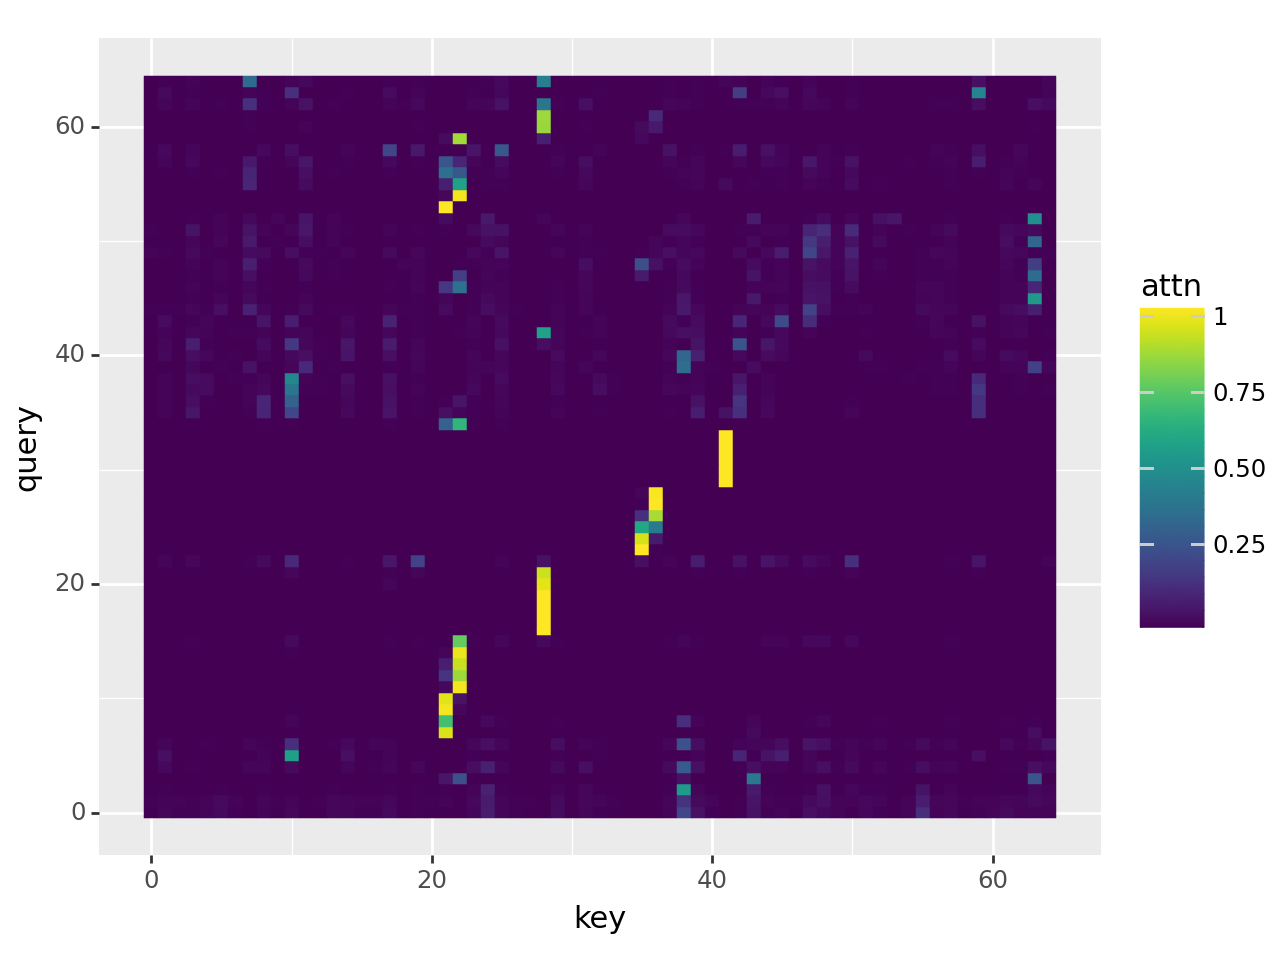

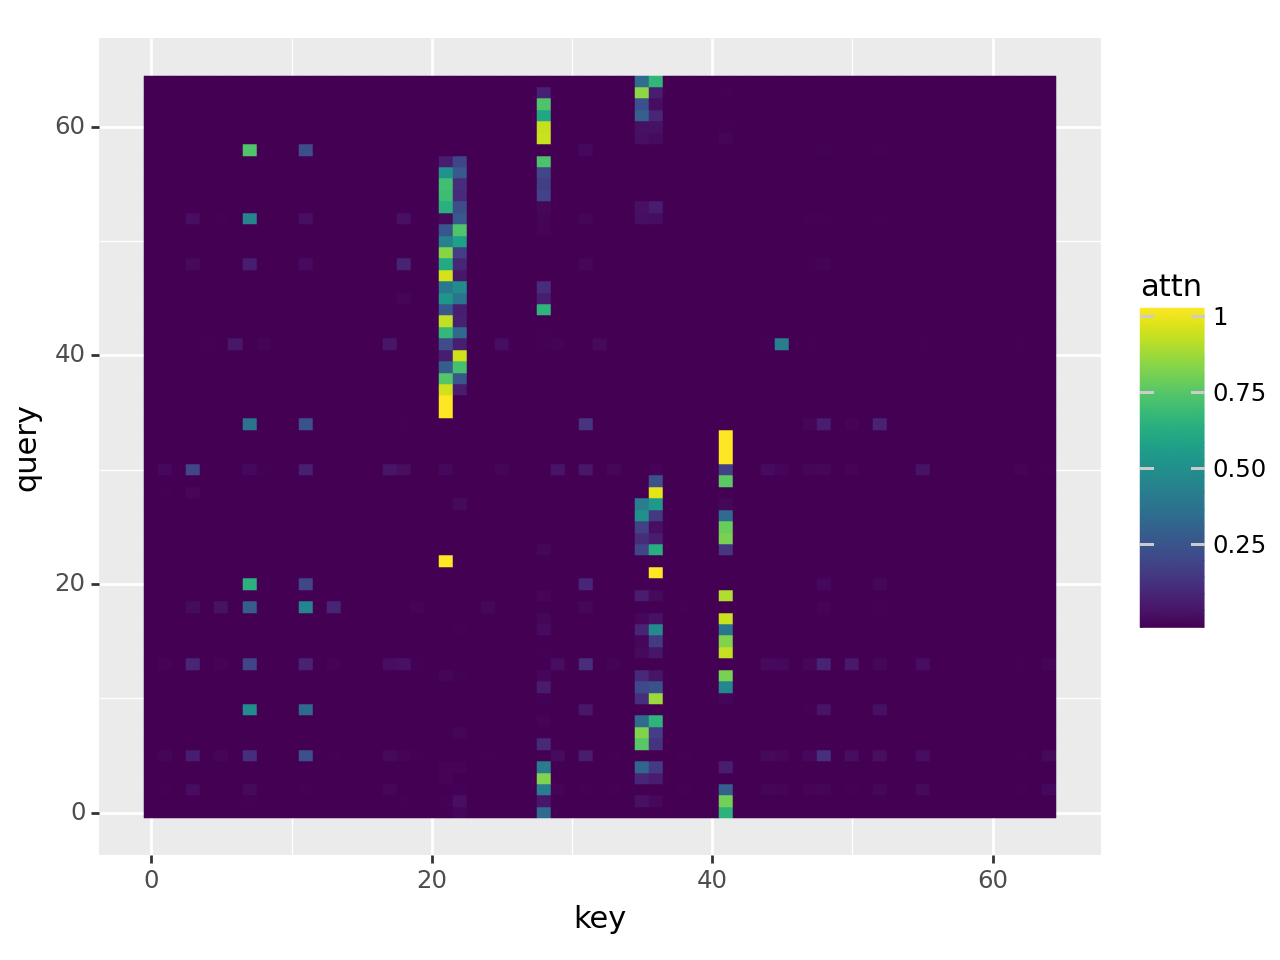

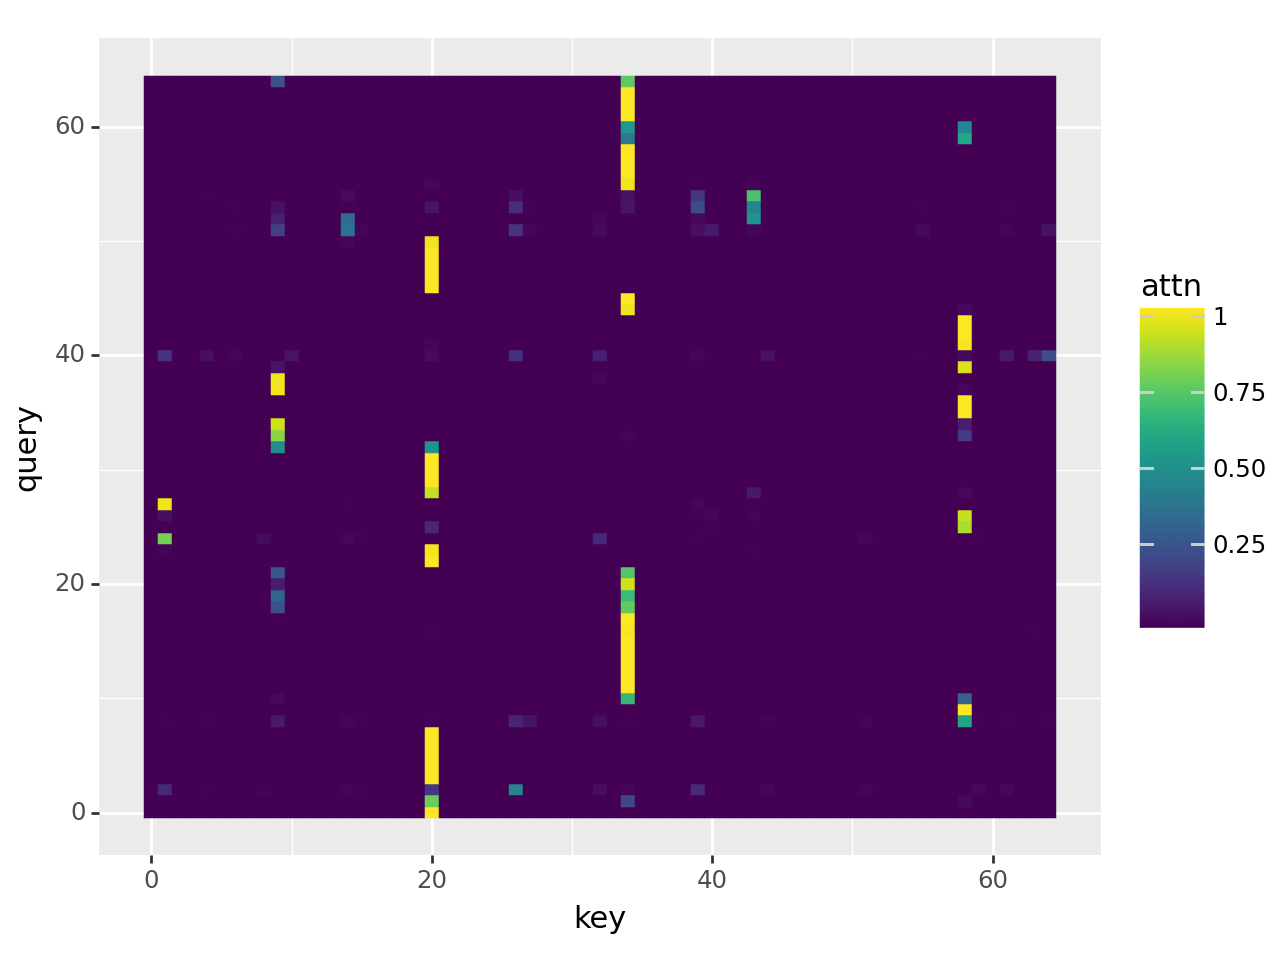

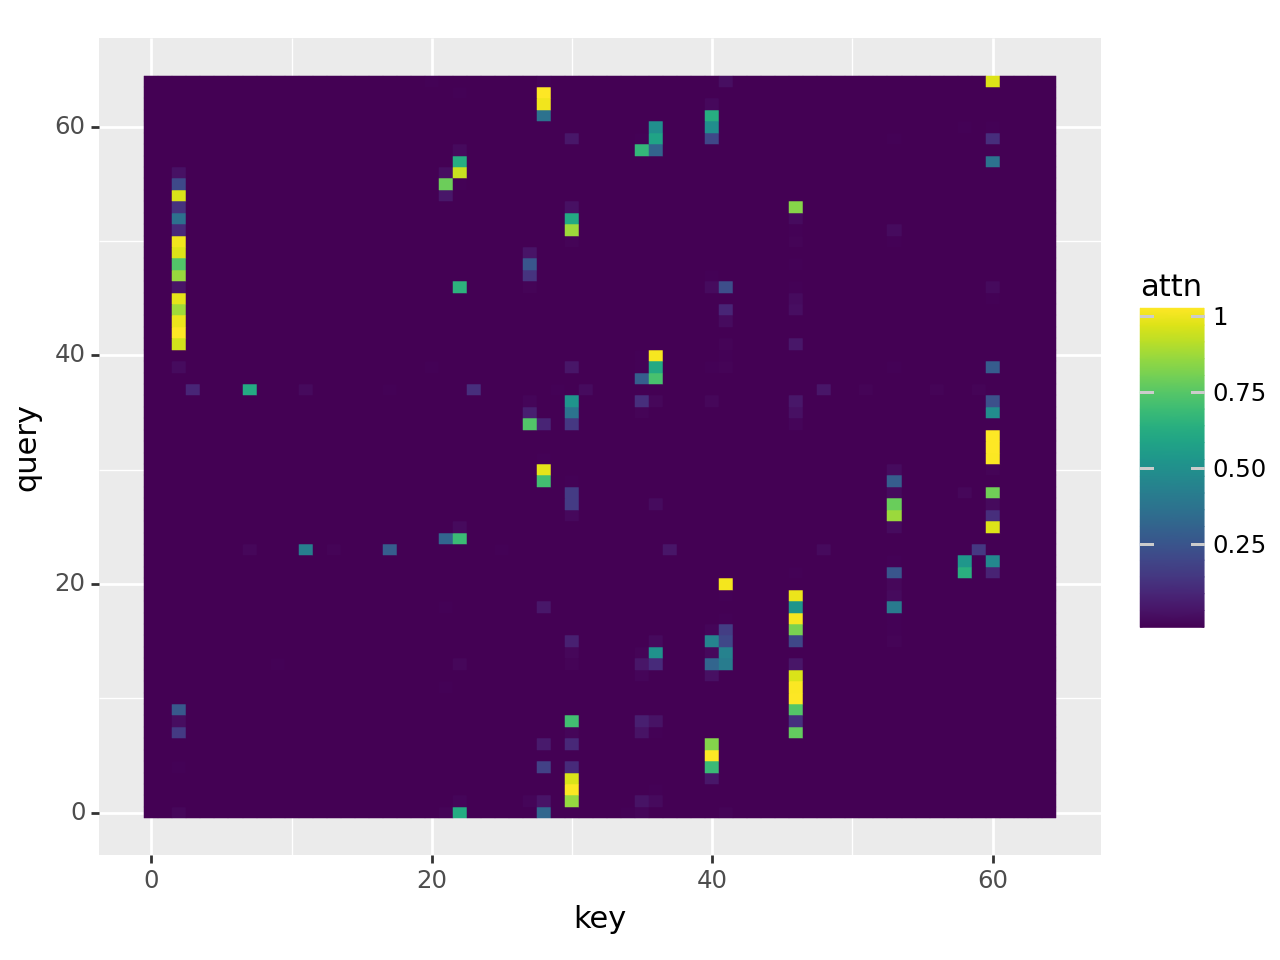

In [101]:
from plotnine import ggplot, geom_point, geom_line, aes, labs, geom_errorbar, facet_wrap, geom_tile

for head in range(4):
    head_key = cf_outputs[-1][0][0][0][head]
    head_query = cf_outputs[-1][1][0][0][head]
    attn = torch.einsum("kh,qh->qk", head_key, head_query).softmax(dim=-1)
    vals = []
    for i in range(attn.shape[0]):
        for j in range(attn.shape[1]):
            vals.append({
                "query": i,
                "key": j,
                "attn": attn[i, j].item()
            })
    df = pd.DataFrame(vals)
    plot = (
        ggplot(df, aes(x="key", y="query", color="attn", fill="attn")) + geom_tile()
    )
    print(plot)

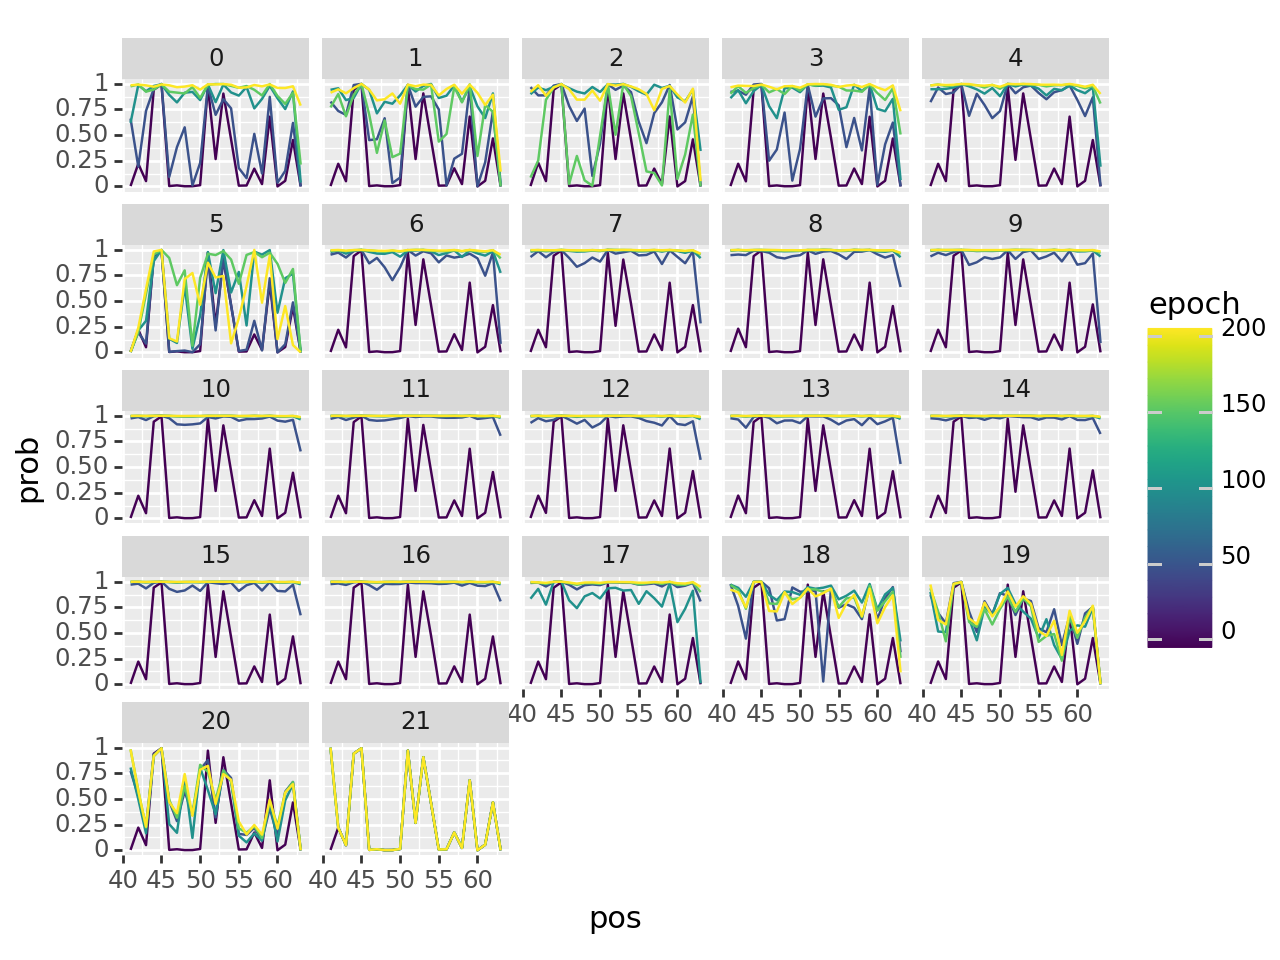

In [68]:
stats2 = [{
    "pos": x['pos'],
    "prob": x['prob'].item(),
    "layer": x['layer'],
    "epoch": int(x['epoch'])
} for x in stats]
df = pd.DataFrame(stats2)
df = df[df["epoch"].isin([0, 50, 100, 150, 200, 250])]

plot = (
    ggplot(df, aes(x="pos", y="prob", color="epoch", group="epoch")) + geom_line() + facet_wrap("~layer")
)
print(plot)

In [ ]:
from pyvene.models.basic_utils import top_vals, format_token

prompt_len = cf_outputs.logits.shape[1]
for i in range(base_prompt_length - 1, prompt_len):
    print(format_token(tokenizer, inputs['input_ids'][0, i].item()))
    top_vals(tokenizer, cf_outputs.logits[0, i].softmax(-1))
    print()

In [29]:
results

{32: [0.0, 0.0, 0.0],
 64: [5.42, 0.01, 0.0],
 128: [1.63, 1.16, 1.95],
 256: [2.9, 3.17, 5.17],
 512: [4.34, 5.06, 4.57],
 1024: [5.11, 4.65, 4.59]}

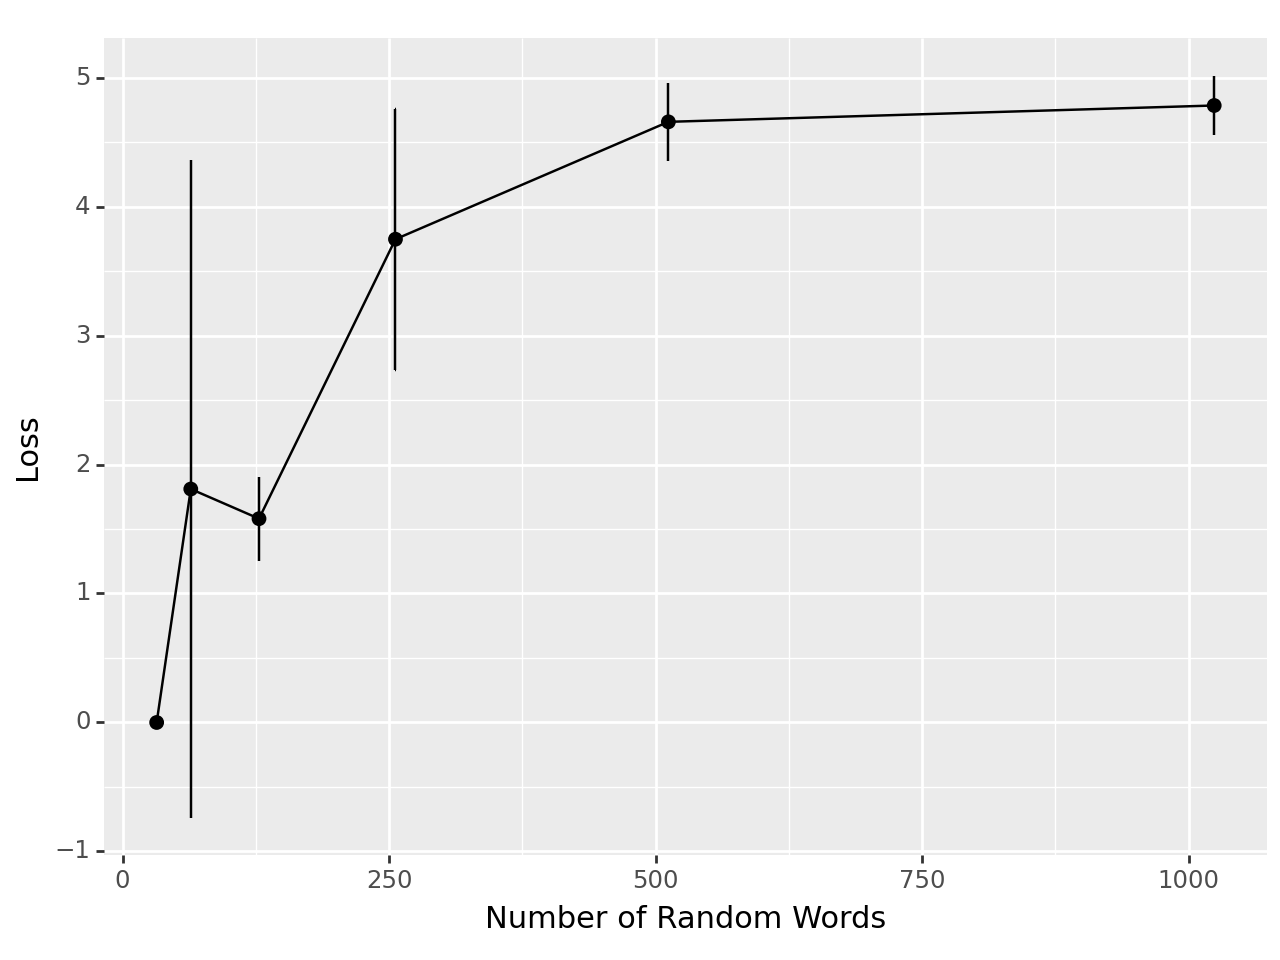

<Figure Size: (640 x 480)>

In [35]:
import pandas as pd
import numpy as np
from plotnine import ggplot, geom_point, geom_line, aes, labs, geom_errorbar

# Transforming the data into a DataFrame
data = {"x": [], "mean": [], "std": [], "variance": []}
for key, values in results.items():
    data["x"].append(key)
    data["mean"].append(np.mean(values))
    data["std"].append(np.std(values))
    data["variance"].append(np.var(values))

df = pd.DataFrame(data)

# Calculating the error (variance here is used as a proxy for error bars)
df['error'] = df['std']

# Plotting
plot = (ggplot(df, aes('x', 'mean')) +
        geom_line() +
        geom_point(size=2) +
        geom_errorbar(aes(ymin='mean-error', ymax='mean+error'), width=0.2) +
        labs(x='Number of Random Words', y='Loss'))

plot